In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import bochamm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.matlib
import pandas as pd
import scipy.stats as stats
import time
import time as timer


from astropy.timeseries import LombScargle
from scipy.stats import qmc
from sloscillations import frequencies, mixed_modes_utils
#from tqdm import tqdm
#from taco.rotation import rotation_utils
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from turbo import Turbo1, TurboM
from turbo.utils import from_unit_cube, latin_hypercube, to_unit_cube
from typing import Optional



In [3]:
def loss_fn(DPi1, q, harmonic=False):

    #if bounds is not None:
    #    DPi1 = (DPi1 * (bounds[0][1] - bounds[0][0])) + bounds[0][0]
     #   q = (q * (bounds[1][1] - bounds[1][0])) + bounds[1][0]
       
    params = {'calc_l0': True, # Compute radial mode properties
            'calc_l2': True, # Compute l=2 mode properties
            'calc_l3': False, # Don't need to calculate l=3 theoretical freqs
            'calc_nom_l1': True, # Compute nominal l=1 p-mode properties
            'calc_mixed': False, # Don't compute mixed modes (as not needed)
            'calc_rot': False, # Don't compute rotation
            'DPi1': DPi1,
            'coupling': q,
            'eps_g': 0.0, # Epsilon_g isn't needed for computation of tau due to chosen formulation of zeta
            'l': 1, # Mixed modes are dipole mixed modes
            }
    # Make computation - in our case this is for the computation of zeta
    freqs(params)
    # Compute tau from the zeta value just computed
    new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(pds_l023_removed.frequency.values, 
                                                               freqs.zeta)

    # If the search range isn't given then default to frequency range 
    # corresponding to period range of 20-400s
    #if search_range is None:
    f = np.arange(1/(400.), 1/(1.), 0.1/tau.max())
    #else:
    #    f = np.arange(1/search_range[1], 1/search_range[0], 0.1/tau.max())

    # Set up Lomb-Scargle periodogram calculation
    ls = LombScargle(tau, pds_l023_removed.power.values)
    PSD_LS = ls.power(f)
   
    # Cut down period and power arrays to search range if given
    
    if harmonic:
        return -(PSD_LS)[np.argmin(np.abs((1/f) - DPi1/2))]
    #else:
    return -(PSD_LS)[np.argmin(np.abs((1/f) - DPi1))]


## Loading in the data

To start with we're going to use a fast rotating star KIC 8564976 (a.k.a KOI-3890). This may seem counter intuitive since going for a complicated case straight away does not seem wise, but all will become clear a little later.

In [4]:
# Load up the summary file, power spectrum and detected peaks
#summary = pd.read_csv('../../TACO_benchmarking/data/intermediate/011353313/summary.csv')
# 002283721
# 002305479
# 002697082
# 003532734
# 004351319
kic = "003749487"
summary = pd.read_csv(f'../../TACO_benchmarking/data/intermediate/{kic}/summary.csv')
#pds = pd.read_csv('../../TACO_benchmarking/data/intermediate/002283721/pds_bgr.csv')#
pds = pd.read_csv(f'../../TACO_benchmarking/data/intermediate/{kic}/pds_bgr.csv')
#peaks = pd.read_csv('../../TACO_benchmarking/data/intermediate/011353313/peaksMLE.csv')#/
peaks = pd.read_csv(f'../../TACO_benchmarking/data/intermediate/{kic}/peaksMLE.csv')

# Only keep pds around oscillations
pds = pds.loc[abs(pds['frequency'].values - summary['numax'].values) < 3 * summary['sigmaEnv'].values, ]

# # If ΔΠ1 is in mega seconds then convert to seconds
# if summary['DeltaPi1'].values < 1:
#     summary['DeltaPi1'] *= 1e6

# Read in and filter peaks file to be within +/-3 sigmaEnv of numax
peaks = peaks.loc[abs(peaks.frequency.values - summary.numax.values) < 3*summary.sigmaEnv.values, ]

# Split the peaks in the l=0,2,3 peaks (which have been already identified)
# and the rest, which should hopefully be unidentified l=3
l023_peaks = peaks.loc[(peaks.l == 0) | (peaks.l == 2) | (peaks.l == 3), ]
l0_peaks = peaks.loc[(peaks.l==0), ]
l1_peaks = peaks.loc[(peaks.l == 1) | (np.isfinite(peaks.l) == False)]

In [5]:
# Divide the data through by the model of the l=0,2 modes
pds_l023_removed = pds.assign(power = pds.power / bochamm.utils.fit_model(pds, l023_peaks))

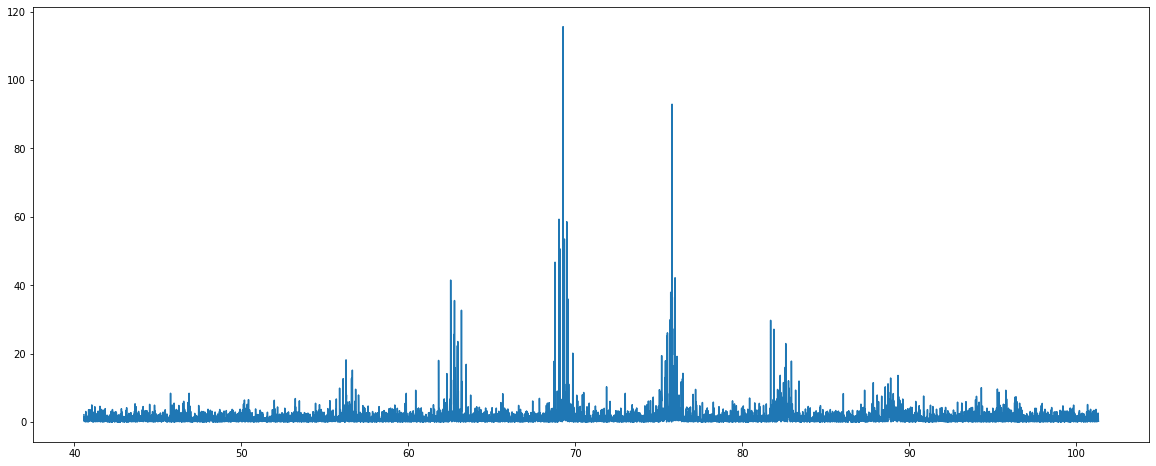

In [6]:
plt.figure(figsize=(20,8))
plt.plot(pds_l023_removed.frequency, pds_l023_removed.power)


In [7]:
# Create artificial frequencies for creation of stretched power spectrum using values determined from TACO for this star
freqs = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                numax=summary.numax.values, 
                                delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)

Best guess DPi1 from PSxPS is 68.65968643971807 s.


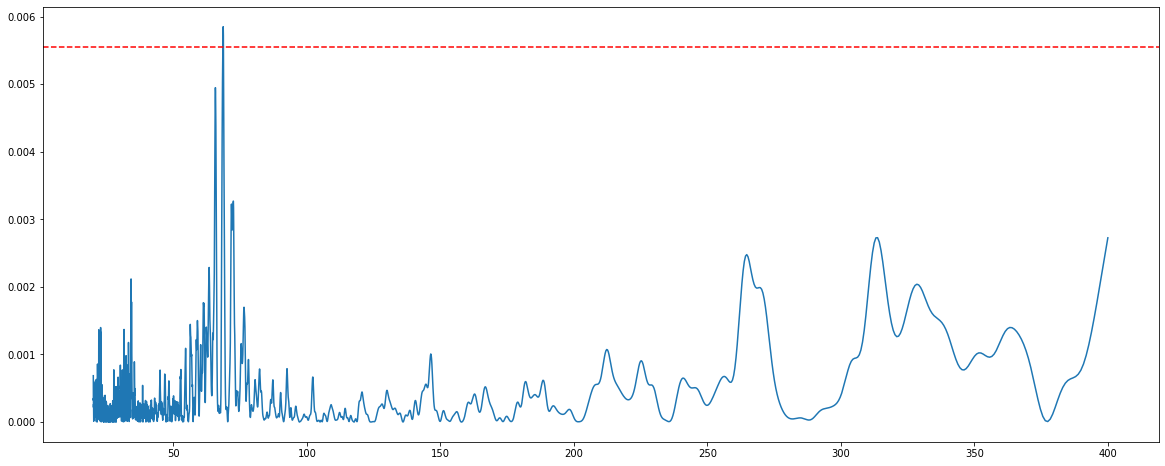

In [8]:
f, PSD_LS = bochamm.utils.compute_PS_PS(pds_l023_removed.frequency.values, pds_l023_removed.power.values, 
                                        bochamm.utils.DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu), 
                                        0.15, freqs,
                                        lower_tau_lim=20, upper_tau_lim=400)

plt.figure(figsize=(20, 8))
plt.plot(1/f, PSD_LS)
dpi1_guess = (1/f)[np.argmax(PSD_LS)]
thresh = np.percentile(PSD_LS, q=99.9)
plt.axhline(thresh, color='r', linestyle='--')
print(f"Best guess DPi1 from PSxPS is {dpi1_guess} s.")
harmonic = False
if dpi1_guess  > 200:
    pass
elif abs(dpi1_guess - (bochamm.utils.DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu)/2))/(bochamm.utils.DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu)/2) < 0.1:
    print("Best guess from PSxPS could be a harmonic, doubling.")
    dpi1_guess *= 2
    harmonic = True
# elif abs(dpi1_guess - bochamm.utils.DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu))/bochamm.utils.DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu) > 0.2:
#     print("Best guess from PSxPS is over 20% from scaling relation, therefore adopting scaling relation as guess.")
#     dpi1_guess = bochamm.utils.DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu)

In [9]:
optim = bochamm.optimise.PSxPSOptimisation(pds_l023_removed, freqs)
X, fX, turbo1 = optim.run_optimisation(init_dpi=dpi1_guess, harmonic=harmonic)

Using dtype = torch.float64 
Using device = cpu
TR-0 starting from: -5.127
TR-1 starting from: -4.738
TR-2 starting from: -5.288
TR-3 starting from: -5.548
425) New best @ TR-3: -5.809
500) New best @ TR-3: -6.044
625) TR-3 converged to: : -6.044
625) TR-3 is restarting from: : -4.012
825) TR-0 converged to: : -5.338
825) TR-0 is restarting from: : -4.702
Elapsed Time:  46.95941925048828
Best value found:
	f(x) = -6.044
Observed at:
	x = [68.531  0.111]


In [11]:
fX = fX.ravel()
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]
best = x_best
best

array([68.53062401,  0.11102098])

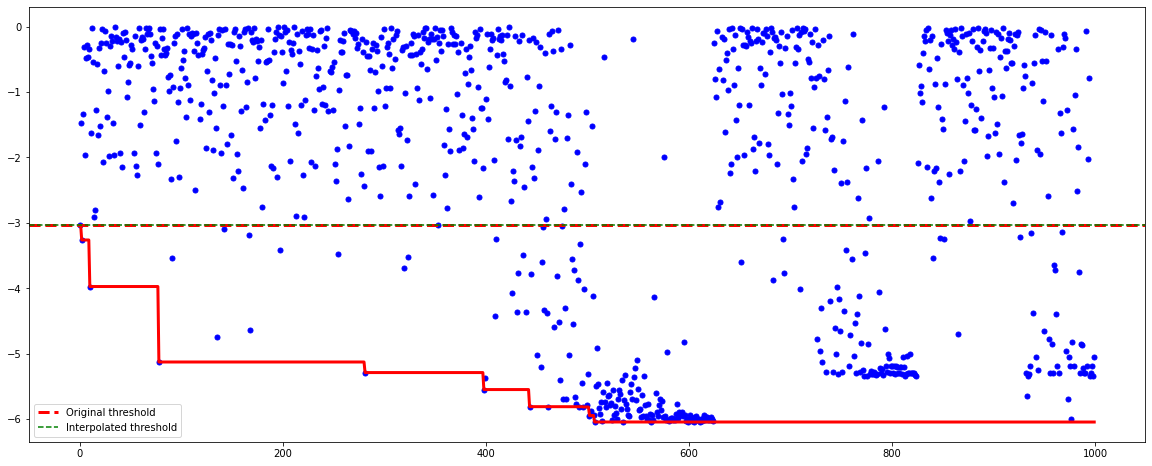

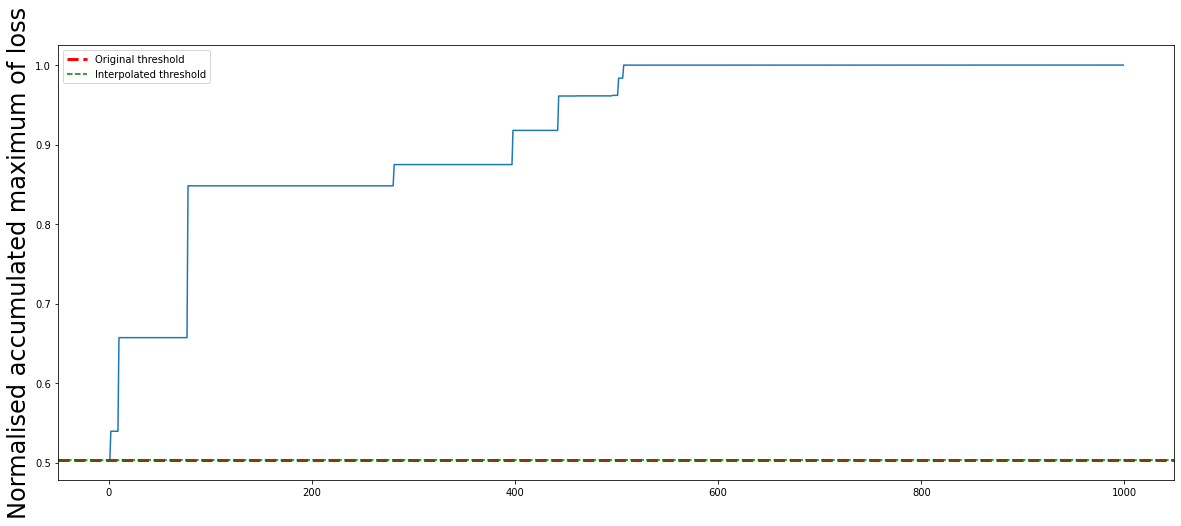

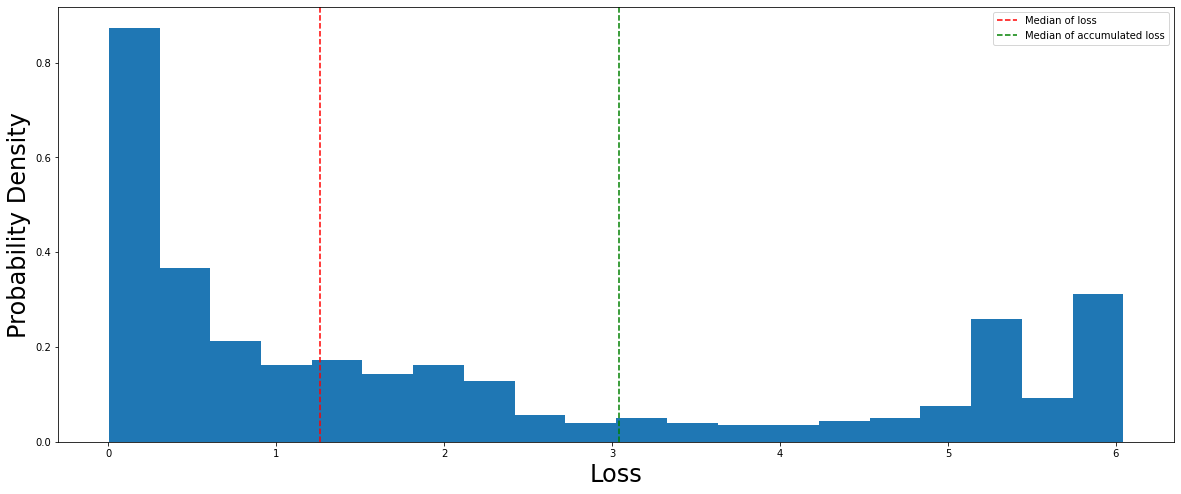

In [12]:
thresh = bochamm.thresholding.Thresholding(X, fX)
red_dat_thresh, threshold = thresh(return_threshold=True, plot=True)

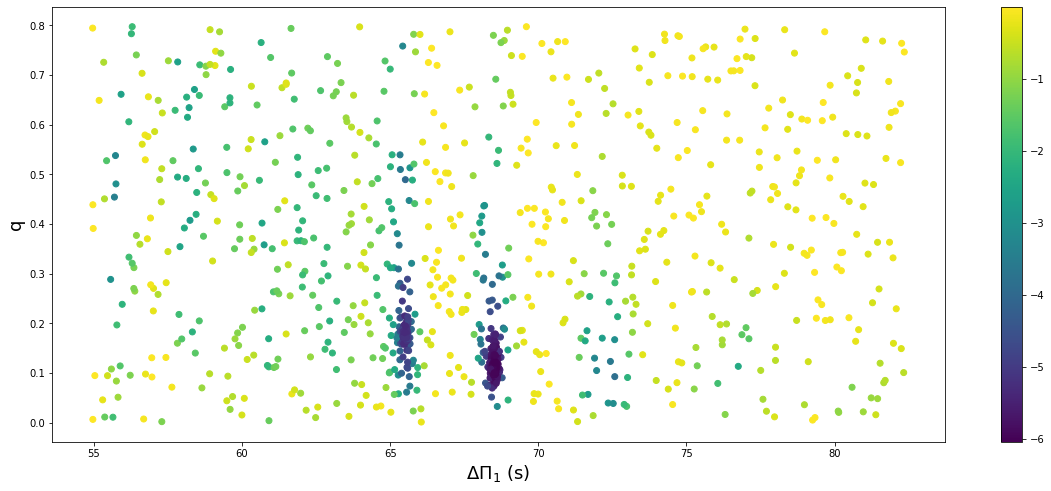

In [13]:
plt.figure(figsize=(20,8))
plt.scatter(X[:,0], X[:,1], c=fX)
plt.xlabel(r'$\Delta\Pi_{1}$ (s)', fontsize=18)
plt.ylabel(r'q', fontsize=18)
plt.colorbar()

Chosen epsilon value is 0.1270477288278194


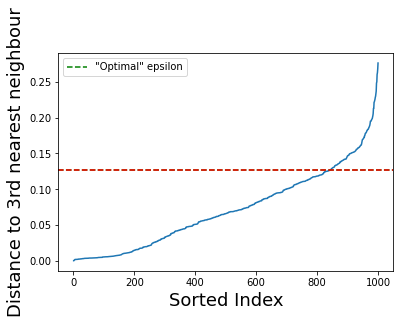

In [14]:
clust = bochamm.clustering.Clustering(X)
reduced_data, cluster_labels = clust(eps=None, min_samples=30, n_neighbours=3, verbose=True, plot=True)

Text(0, 0.5, 'Coupling')

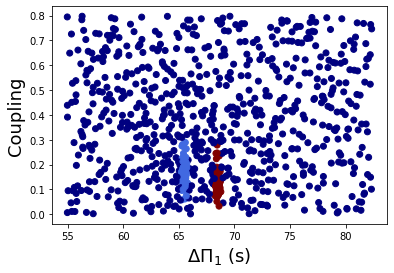

In [15]:
clusters = clust.clustering_algorithm.labels_
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X[:,0], X[:,1], c=vectorizer(clusters))
plt.xlabel(r'$\Delta\Pi_{1}$ (s)', fontsize=18)
plt.ylabel(r'Coupling', fontsize=18)

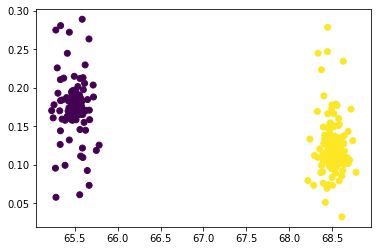

In [16]:
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=cluster_labels)

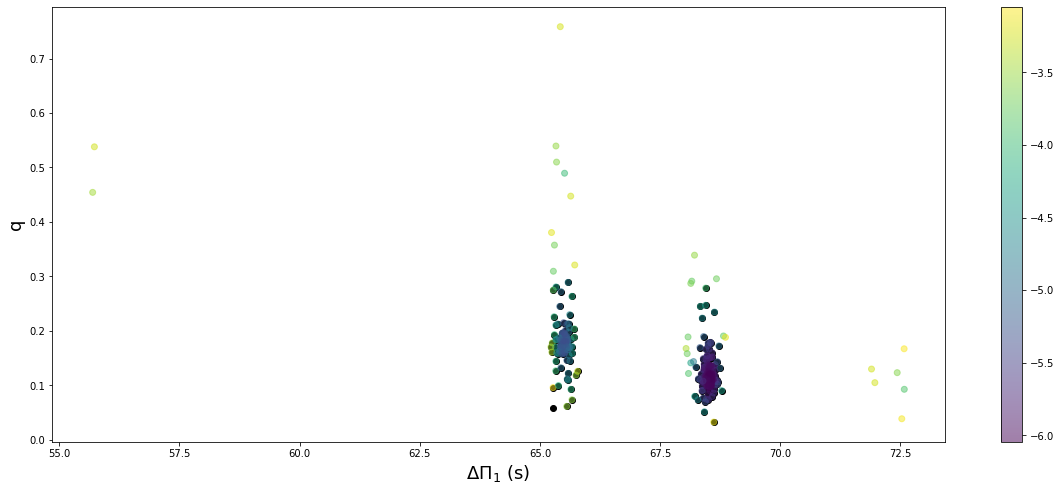

In [17]:
cond = (-fX > threshold) 
plt.figure(figsize=(20,8))
plt.scatter(reduced_data[:,0], reduced_data[:,1], c='k')
plt.scatter(X[cond,0], X[cond,1], c=fX[cond], alpha=0.5)


plt.xlabel(r'$\Delta\Pi_{1}$ (s)', fontsize=18)
plt.ylabel(r'q', fontsize=18)
plt.colorbar()

In [18]:
# Set up for clustering
X_clust = X[-fX.ravel() > threshold, :]

[-1  0  1]
[-1  0  1]
[-1  0  1]


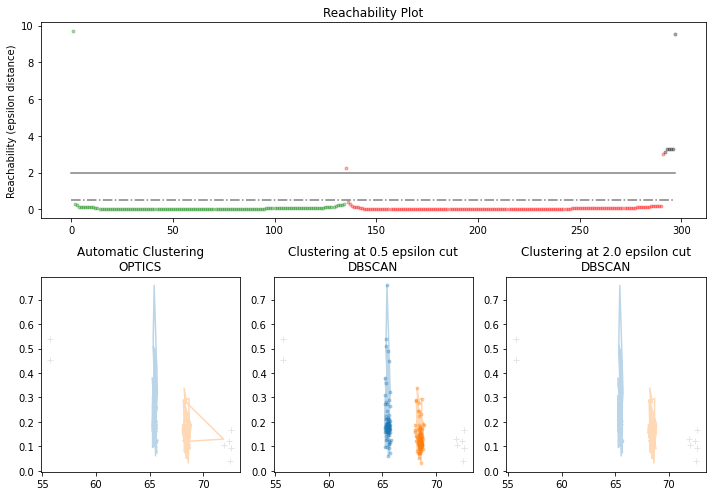

In [19]:
# Hyperparameters still need to be robustly decided, but these aren't too bad
#clust = OPTICS(min_samples=100, max_eps=1, xi=0.05, min_cluster_size=0.05)
clust = OPTICS(min_samples=30, xi=0.5, min_cluster_size=0.05)

# Run the fit
clust.fit(X_clust)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(X_clust))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

print(np.unique(labels))
print(np.unique(labels_050))
print(np.unique(labels_200))

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, labels.max()+1), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = [f"C{i}" for i in range(10)]
#colors = ["g.", "r.", "b.", "y.", "c.", "C0", "C1"]
for klass, color in zip(range(0, labels.max()+1), colors):
    Xk = X_clust[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X_clust[clust.labels_ == -1, 0], X_clust[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
#colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, labels_050.max()+1), colors):
    Xk = X_clust[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker=".")
ax3.plot(X_clust[labels_050 == -1, 0], X_clust[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
#colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, labels_200.max()+1), colors):
    Xk = X_clust[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X_clust[labels_200 == -1, 0], X_clust[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In [20]:
n_solns = (np.unique(clust.labels_) >= 0).sum()
print(f"There are {n_solns} estimated solutions.")

There are 2 estimated solutions.


NameError: name 'Y' is not defined

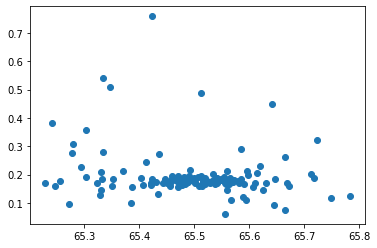

In [21]:
for i in range(n_solns):
    #plt.scatter(samples[cond][clust.labels_ == i, 0], samples[cond][clust.labels_ == i, 1]) 
    plt.scatter(X_clust[clust.labels_ == i, 0], X_clust[clust.labels_ == i, 1]) 
    print(np.mean(Y[clust.labels_ == i]))
plt.axvline(best[0], color='r', linestyle='--')
plt.axhline(best[1], color='r', linestyle='--')

In [302]:
for i in range(n_solns):
    print(f"Results from solution {i+1}")
    print(f"Loss: {np.mean(Y[clust.labels_ == i])}")
    print(f"DPi1 (s): {np.percentile(X_clust[clust.labels_ == i, 0], q=[2.5, 16, 50, 84, 97.5])}")
    print(f"q: {np.percentile(X_clust[clust.labels_ == i, 1], q=[2.5, 16, 50, 84, 97.5])}")
    print("*"*100)
best[0], best[1]

Results from solution 1
Loss: 5.828176005189681
DPi1 (s): [68.33066392 68.44170054 68.52847246 68.58935243 68.66957663]
q: [0.08424115 0.10210612 0.11771427 0.13887164 0.17991849]
****************************************************************************************************
Results from solution 2
Loss: 4.9273469548926565
DPi1 (s): [65.3250005  65.4317065  65.52195453 65.61159575 65.66900009]
q: [0.10563286 0.13664391 0.17291358 0.22357487 0.2428156 ]
****************************************************************************************************


(68.5509060896569, 0.11056553223968324)

Results from solution 1
Loss: 5.828176005189681
DPi1 (s): [68.44170054 68.52847246 68.58935243]
q: [0.10044007 0.11771427 0.13887164]
****************************************************************************************************
68.52847245617251


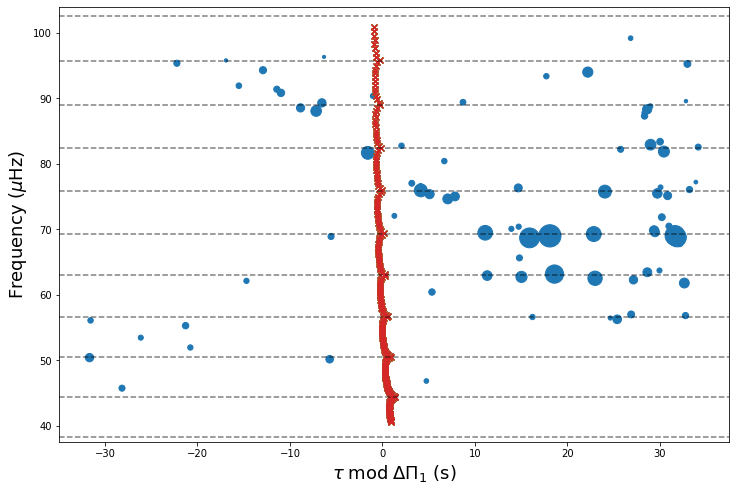

Results from solution 2
Loss: 4.9273469548926565
DPi1 (s): [65.4317065  65.52195453 65.61159575]
q: [0.13430155 0.17291358 0.22357487]
****************************************************************************************************
65.52195452714287


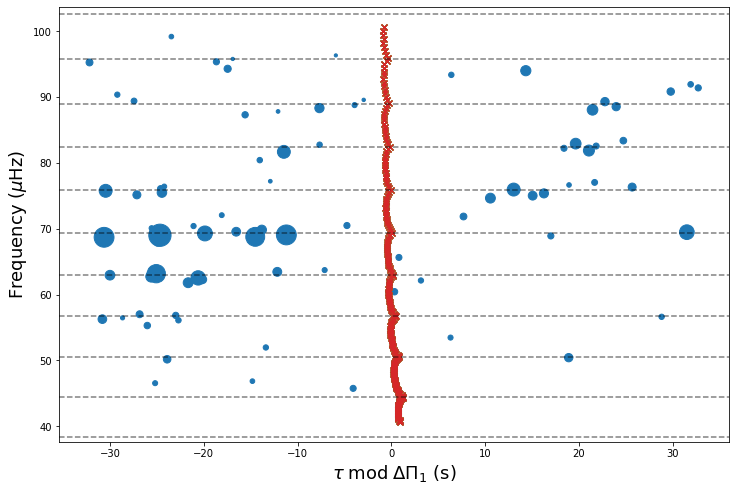

In [303]:
for i in range(n_solns):
    print(f"Results from solution {i+1}")
    print(f"Loss: {np.mean(Y[clust.labels_ == i])}")
    print(f"DPi1 (s): {np.percentile(X_clust[clust.labels_ == i, 0], q=[16, 50, 84])}")
    print(f"q: {np.percentile(X_clust[clust.labels_ == i, 1], q=[14, 50, 84])}")
    print("*"*100)
    refined_dpi = np.percentile(X_clust[clust.labels_ == i, 0], q=50)
    refined_eps_g = 0.0
    print(refined_dpi)
    refined_split = 0
    refined_coupling = np.percentile(X_clust[clust.labels_ == i, 1], q=50)
    freqs, real_tau = bochamm.plotting.plot_results(pds, summary, l1_peaks, [-5, 5], refined_dpi, refined_coupling, refined_eps_g, refined_split)#, new_d01)
    plt.show()

In [210]:
best
# 76.462  0.119  0.202  0.594

array([71.59034011,  0.0984731 ])

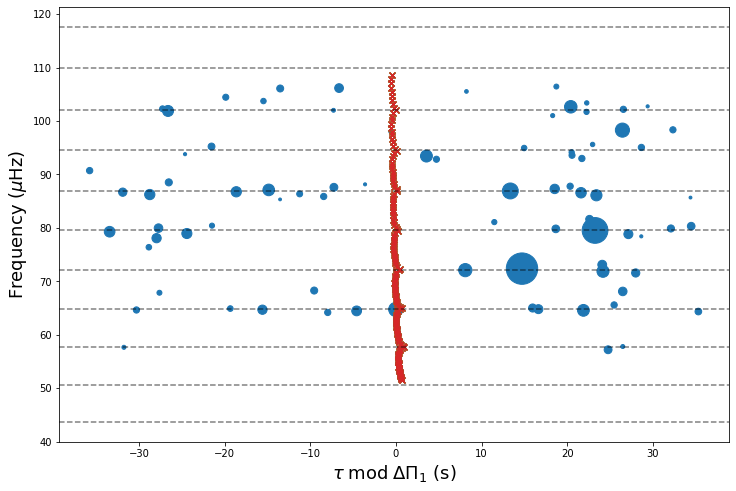

In [211]:
freqs, real_tau = bochamm.plotting.plot_results(pds, summary, l1_peaks, [-5, 5], best[0], best[1], 0.0, 0.0)#, new_d01)
plt.show()